In [1]:
%cd ..

/home/clement/Dropbox/MVA/Graphs in ML/project/graphConvNet


# What is Convolution on Graph?

To apply convolution, GSP proposes to enforce the convolution theorem with the convolution operator on graph $*_\mathcal{G}$:
$$\widehat{x*_\mathcal{G}y} = \hat{x}\odot\hat{y}$$

Hence, we can convolve a filter $k$ over a signal $x$ by applying:
$$x*_\mathcal{G}k = U((U^Tx)\odot(U^Tk))$$

## Experiments

We again, consider an grid graph with an mnist signal.

In [2]:
import pygsp
import numpy
import scipy.misc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
%matplotlib inline

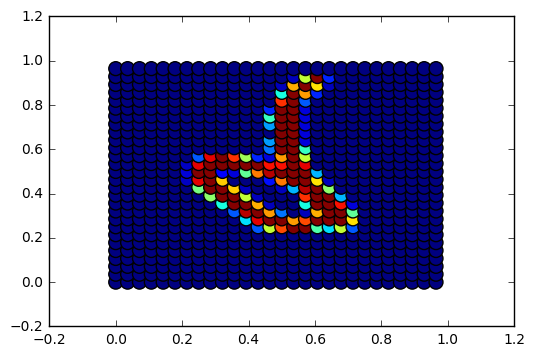

In [3]:
mnist = scipy.misc.imread("data/mnist.png", flatten=True)/255
gsz = mnist.shape[0]
mnist = numpy.reshape(mnist,[mnist.size,1])
mnist = numpy.float64(mnist)
g = pygsp.graphs.Grid2d(gsz)
g_toy = pygsp.graphs.Grid2d(4)
pygsp.plotting.plot_signal(g, mnist)
g.compute_fourier_basis()

## Convolution with a Gaussian Kernel

We can see on the following example, that in the case of our 2D image sample, the convolution of $x$ with a gaussian kernel does not produce the same effect as classic convolutions. 

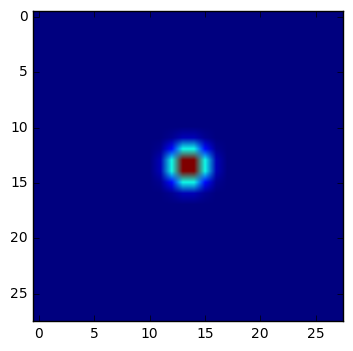

In [4]:
k1 = scipy.signal.gaussian(gsz,1)
k2 = scipy.signal.gaussian(gsz,1)
K = numpy.outer(k1,k2)
plt.imshow(K)
K = numpy.reshape(K,[K.size,1])

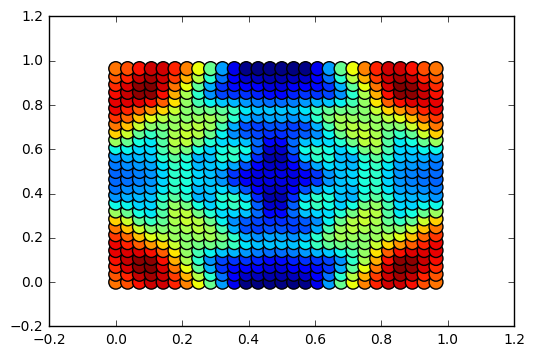

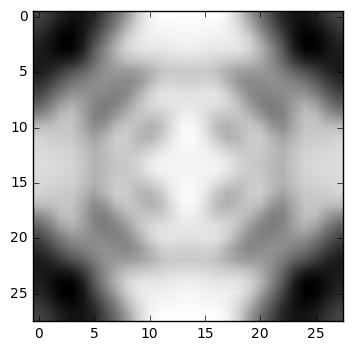

In [5]:
mnist_f = g.U.T.dot(mnist)
K_f = g.U.T.dot(K)
conv_f = numpy.multiply(mnist_f,K_f)
conv = g.U.dot(conv_f)
conv = numpy.asarray(conv)
pygsp.plotting.plot_signal(g,conv)
plt.show()
plt.imshow(numpy.reshape(conv,[gsz,gsz]), cmap='Greys')

This little experiment shows us that the convolution on graph does not have the same behaviour as 2D signal convolution. This helps us to understand the choice of authors to use filters directely defined in the fourier basis:
$$y = Ug_\theta U^Tx$$
With 
$$g_\theta = diag(\theta)$$

For now on, we don't have much ideas of what such a filter should look like on the fourier basis though.

## The Polynomial Parametrization is Localized

In the paper, the authors propose to use a polynomial parametrization of such a filter, using the eigenvalues matrix $\Lambda$:
$$g_\theta(\Lambda) = \sum_{k=0}^{K-1}\theta_k\Lambda^k$$
This polynomial has the advantage to respect the form proposed earlier, and most importantly to be proved to be localized. Indeed, it has been shown that considering two nodes with indexes $i,j$:
$$d(i,j)>K \Rightarrow (L^K)_{ij} = 0$$
With $d(i,j)$, the length of the shortest path between the $i,j$ nodes.

Thus, using $\Lambda^K$ as filter, allows us to define K-localized filters on nodes.

We can check that on the $g_{toy}$ graph:

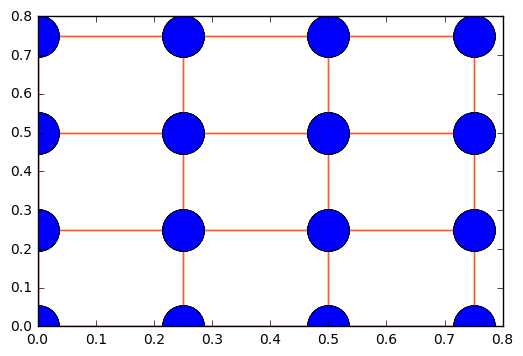

In [6]:
pygsp.plotting.plot_graph(g_toy)

Plotting power 1 of Laplacian


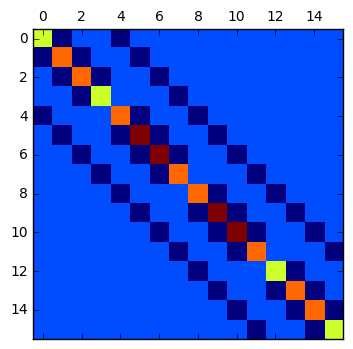

Plotting power 2 of Laplacian


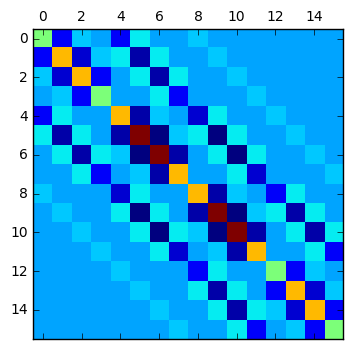

Plotting power 3 of Laplacian


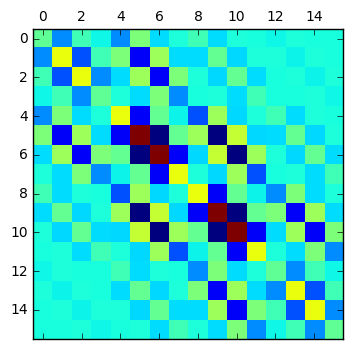

Plotting power 4 of Laplacian


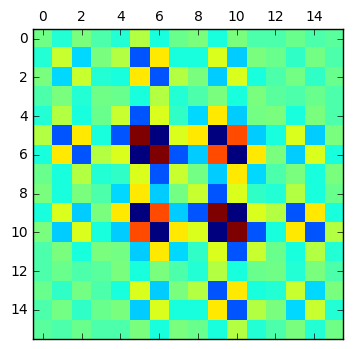

Plotting power 5 of Laplacian


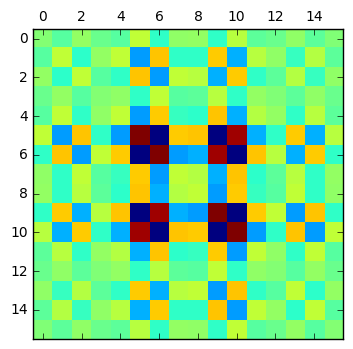

Plotting power 6 of Laplacian


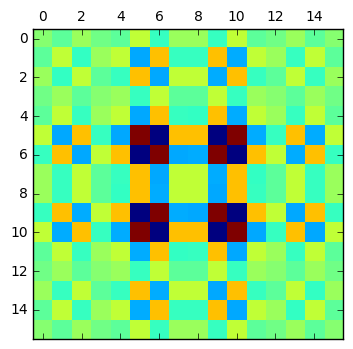

In [7]:
L = numpy.float64(g_toy.L.todense())
print("Plotting power 1 of Laplacian")
plt.matshow(L)
plt.show()
for i in range(2,7):
    print("Plotting power %i of Laplacian"%i)
    L = L.dot(L)
    plt.matshow(L)
    plt.show()

If we consider the max path length between nodes $1,2$, we can see that $\forall k \in [1,K], (L^K)_{1,2} \neq 0$:

In [8]:
L = numpy.float64(g_toy.L.todense())
node1 = 1
node2 = 2
for i in range(1,7):
    val = numpy.linalg.matrix_power(L,i)[node1,node2]
    print(val)

-1.0
-6.0
-33.0
-182.0
-1030.0
-6012.0


## Convolution with $\Lambda^K$ filters

Now if we try to convolve our signal with some powers of lambda, as it is proposed we have the following:

Plotting \Lambda^1 filtered signal


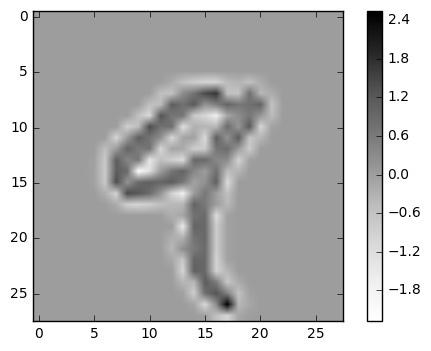

Plotting \Lambda^2 filtered signal


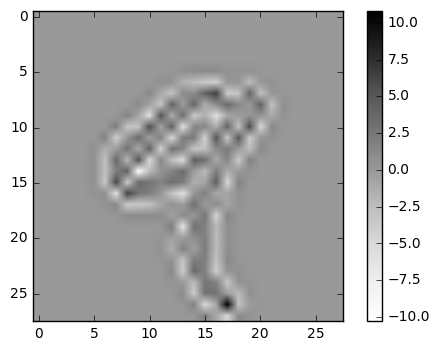

Plotting \Lambda^3 filtered signal


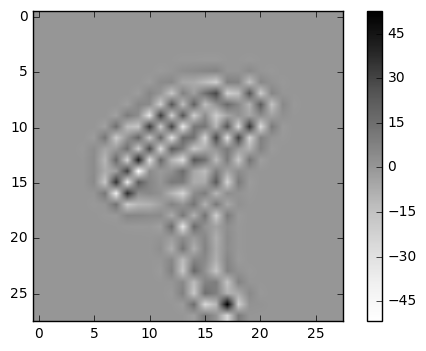

Plotting \Lambda^4 filtered signal


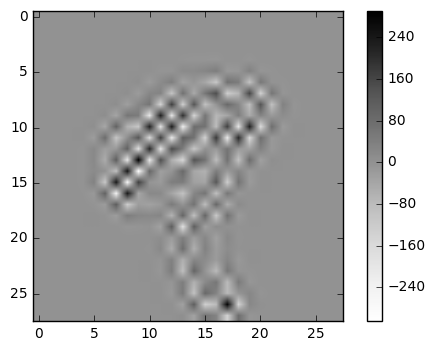

Plotting \Lambda^5 filtered signal


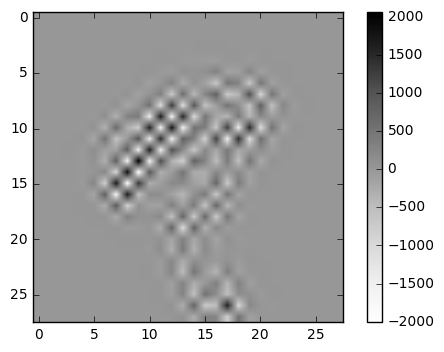

Plotting \Lambda^6 filtered signal


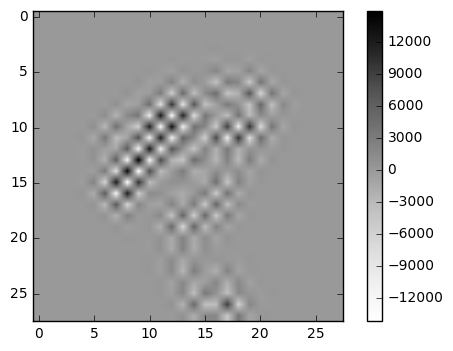

Plotting \Lambda^7 filtered signal


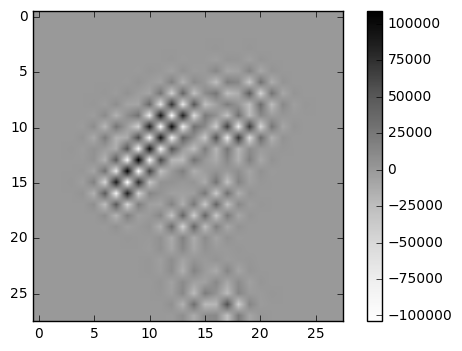

Plotting \Lambda^8 filtered signal


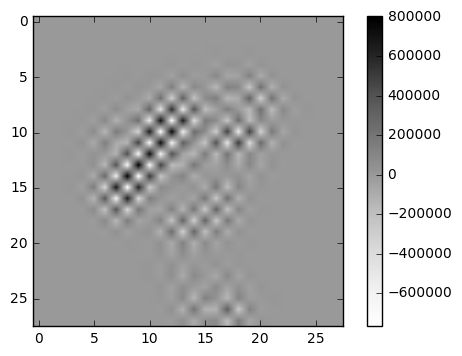

Plotting \Lambda^9 filtered signal


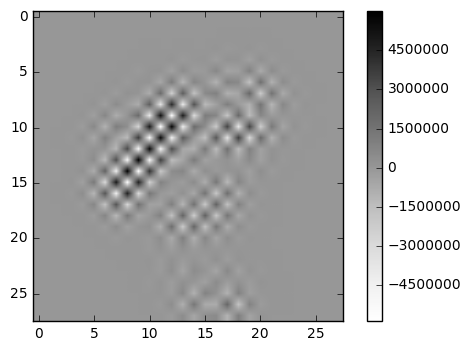

In [9]:
Lambda, u = numpy.linalg.eig(g.L.todense())
Lambda = Lambda[numpy.argsort(Lambda)]
Lambda = numpy.reshape(Lambda,[Lambda.size,1])

for i in range(1,10):
    fig = plt.figure()
    print("Plotting \Lambda^%i filtered signal"%i)
    Lambda_k = numpy.power(Lambda,i)
    mnist_f = g.U.T.dot(mnist)
    conv_f = numpy.multiply(mnist_f,Lambda_k)
    conv = g.U.dot(conv_f)
    plt.imshow(numpy.reshape(conv,[gsz,gsz]), cmap='Greys')
    plt.colorbar()
    plt.show()    

## Does the $\Lambda^k$ filters make sense in the normal basis?

If we try to see what the $\Lambda$ filter looks like when projected back in the normal basis, we will see that we can not interpret much about it. This will be inconvenient, because we won't be able to interpret filters as it is the case with classic CNNs.

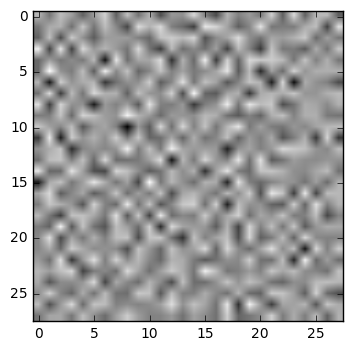

In [10]:
Lambda_k = numpy.power(Lambda,1)
Lambda_k_c = g.U.dot(Lambda_k)
plt.imshow(numpy.reshape(Lambda_k_c,[gsz,gsz]), cmap='Greys')

## Recursive computation with $L$

A point still unclear with the paper is the need to use a Chebyshev polynomial to recursively compute the filtered signals. As we can see in the following, this is easily done using the laplacian:

Plotting 0 recursive filtered signal


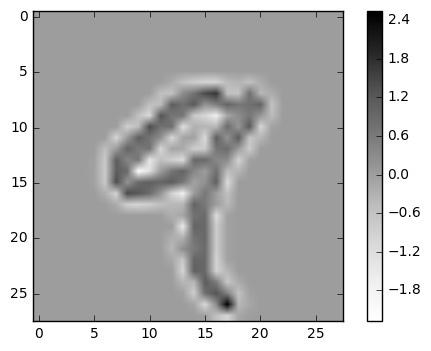

Plotting 1 recursive filtered signal


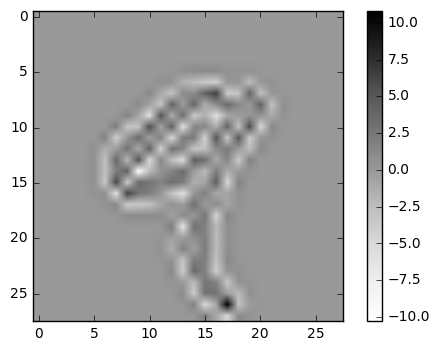

Plotting 2 recursive filtered signal


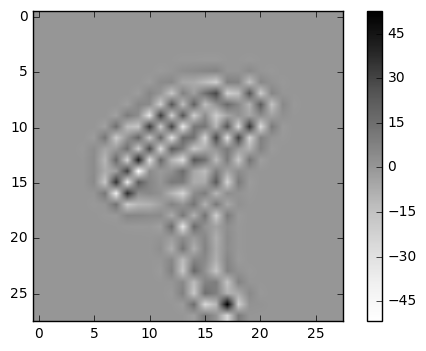

Plotting 3 recursive filtered signal


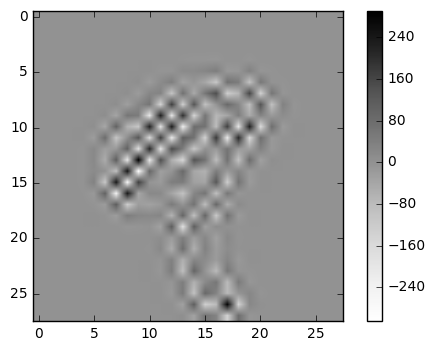

Plotting 4 recursive filtered signal


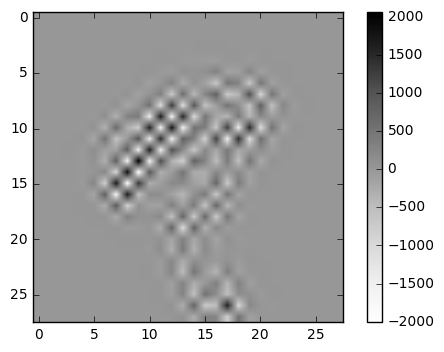

Plotting 5 recursive filtered signal


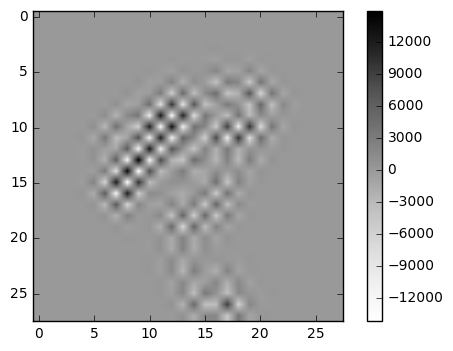

Plotting 6 recursive filtered signal


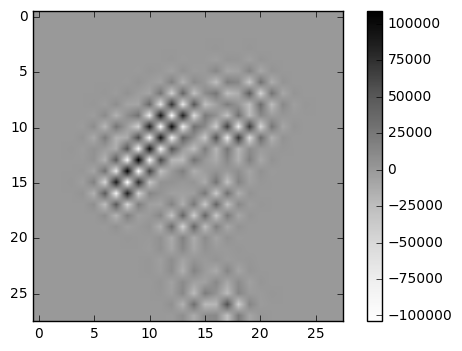

Plotting 7 recursive filtered signal


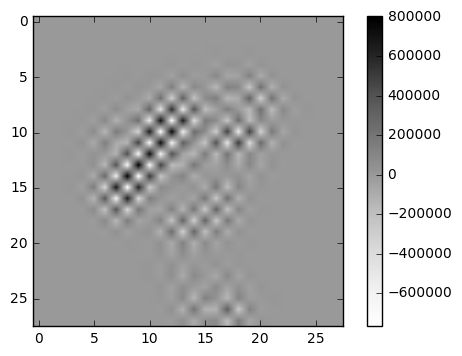

Plotting 8 recursive filtered signal


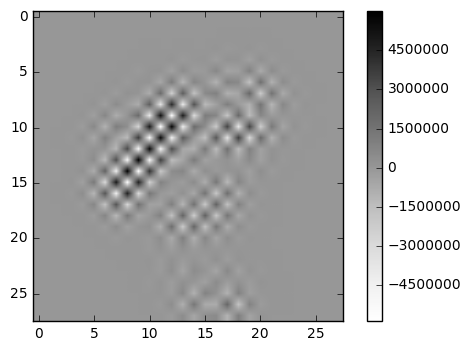

Plotting 9 recursive filtered signal


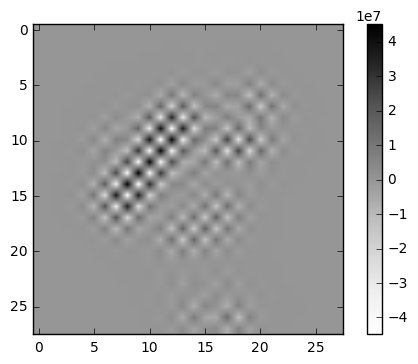

CPU times: user 9.65 s, sys: 36 ms, total: 9.69 s
Wall time: 2.61 s


In [11]:
%%time
L = g.L.todense()
L_inv = numpy.linalg.inv(L)
recur = mnist
for i in range(0,10):
    print("Plotting %i recursive filtered signal"%i)
    recur = L.dot(recur)
    plt.imshow(numpy.reshape(recur,[gsz,gsz]), cmap='Greys')
    plt.colorbar()
    plt.show()

## Recursive computation with Chebyshev Polynomials

If we compute the Chebyshev Laplacian polynomials, the $k$ filtered signals are different from the ones computed with recursive laplacian.

Plotting 0 recursive filtered signal


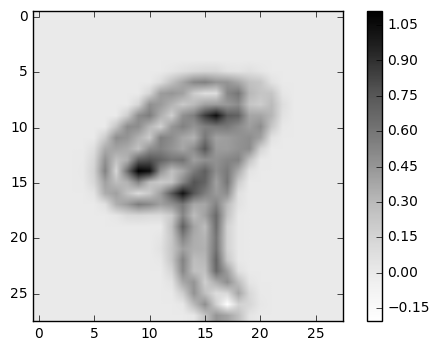

Plotting 1 recursive filtered signal


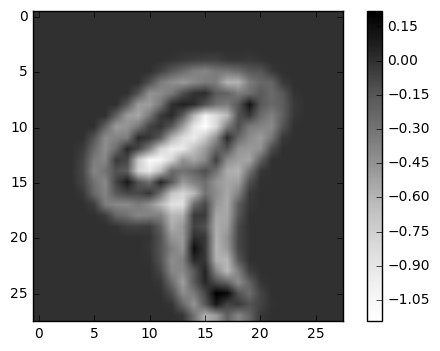

Plotting 2 recursive filtered signal


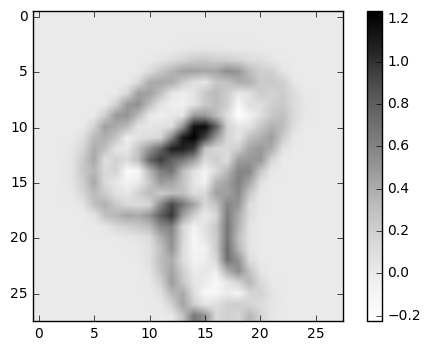

Plotting 3 recursive filtered signal


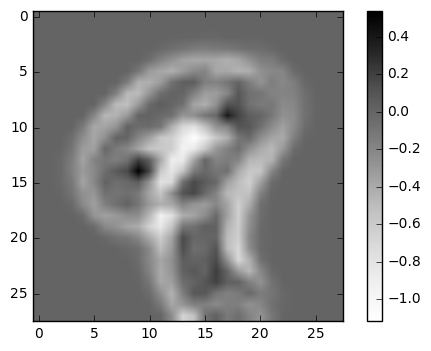

Plotting 4 recursive filtered signal


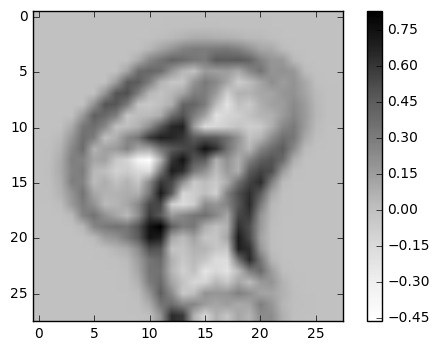

Plotting 5 recursive filtered signal


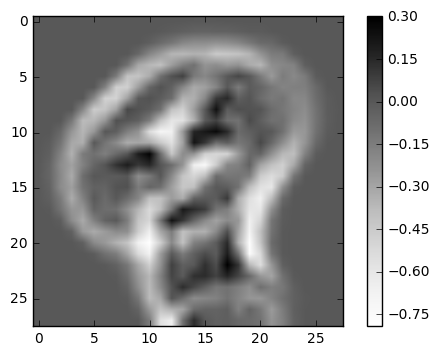

Plotting 6 recursive filtered signal


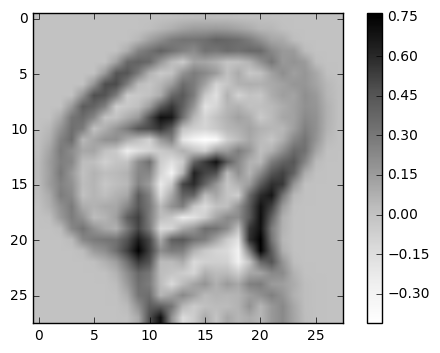

Plotting 7 recursive filtered signal


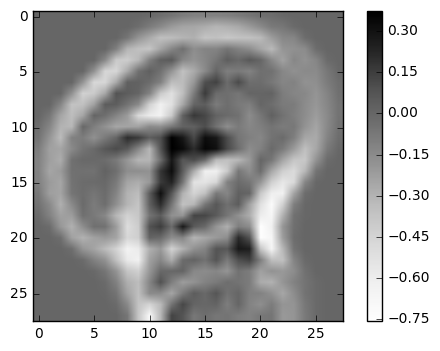

Plotting 8 recursive filtered signal


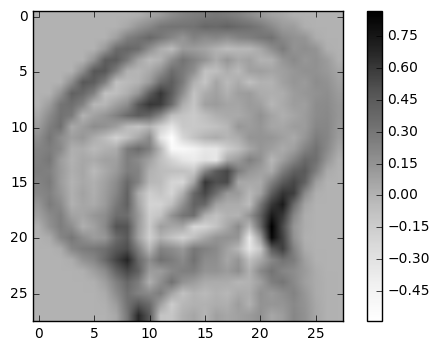

Plotting 9 recursive filtered signal


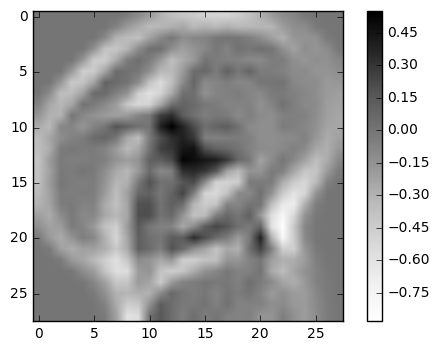

CPU times: user 8.93 s, sys: 28 ms, total: 8.96 s
Wall time: 2.63 s


In [12]:
%%time
L = g.L.todense()
L_t = (2/Lambda.max())*L - numpy.eye(gsz*gsz)
x_m1 = L_t.dot(mnist)
x_m2 = mnist
for i in range(0,10):
    print("Plotting %i recursive filtered signal"%i)
    x = 2*L_t.dot(x_m1)-x_m2
    plt.imshow(numpy.reshape(x,[gsz,gsz]), cmap='Greys')
    plt.colorbar()
    plt.show()
    x_m2 = x_m1
    x_m1 = x